In [5]:
import os
import zipfile
import numpy as np
import tensorflow as tf

from tensorflow import keras
from keras import layers


In [ ]:
# Download dataset

folder_path = r'D:\dataset\MosMedData'

url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip"
filename = os.path.join(os.getcwd(), "CT-0.zip")
keras.utils.get_file(filename, url)

url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip"
filename = os.path.join(os.getcwd(), "CT-23.zip")
keras.utils.get_file(filename, url)

os.makedirs(folder_path)

with zipfile.ZipFile("CT-0.zip", "r") as z_fp:
    z_fp.extractall(folder_path)

with zipfile.ZipFile("CT-23.zip", "r") as z_fp:
    z_fp.extractall(folder_path)

In [6]:
import nibabel as nib
from scipy import ndimage


def read_nifti_file(filepath):
    scan = nib.load(filepath)
    scan = scan.get_fdata()
    return scan

def normalize(volume):
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype('float32')
    return volume

def resize_volume(img):
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    (current_width, current_height, current_depth) = img.shape

    depth = current_depth/ desired_depth
    width = current_width / desired_width
    height = current_height / desired_height

    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height

    img = ndimage.rotate(img, 90, reshape=False)

    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

def process_scan(path):
    volume = read_nifti_file(path)
    volume = normalize(volume)
    volume = resize_volume(volume)
    return volume
    

In [7]:
folder_path = r'D:\dataset\MosMedData'
normal_scan_paths = [
    os.path.join(os.getcwd(), f'{folder_path}/CT-0', x)
    for x in os.listdir(f'{folder_path}/CT-0')
]

abnormal_scan_paths = [
    os.path.join(os.getcwd(), f'{folder_path}/CT-23', x)
    for x in os.listdir(f'{folder_path}/CT-23')
]

print(f'CT scans with normal lung tissues: {len(normal_scan_paths)}')
print(f'CT scans with abnormal lung tissues: {len(abnormal_scan_paths)}')

CT scans with normal lung tissues: 100
CT scans with abnormal lung tissues: 100


In [43]:
# build train and validation dataset

abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])
normal_scans = np.array([process_scan(path) for path in normal_scan_paths])
abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

x_train = np.concatenate((abnormal_scans[:70], normal_scans[:70]), axis=0)
y_train = np.concatenate((abnormal_labels[:70], normal_labels[:70]), axis=0)
x_val = np.concatenate((abnormal_scans[70:], normal_scans[70:]), axis=0)
y_val = np.concatenate((abnormal_labels[70:], normal_labels[70:]), axis=0)

print(
    f'Number of samples in train and validation are {x_train.shape[0]} and {x_val.shape[0]}'
)


[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  ...

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 

In [44]:
# augment data

import random
from scipy import ndimage

@tf.function
def rotate(volume):

    def scipy_rotate(volume):
        angles = [-20, -10, -5, 5, 10, 20]
        angle = random.choice(angles)
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume

def train_preprocessing(volume, label):
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

def validation_preprocessing(volume, label):
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [46]:
# define data loader

train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
train_dataset = train_loader.shuffle(len(x_train)).map(train_preprocessing).batch(batch_size).prefetch(2)
validation_dataset = validation_loader.shuffle(len(x_val)).map(validation_preprocessing).batch(batch_size).prefetch(2)

dimension of the CT scan is: (128, 128, 64, 1)


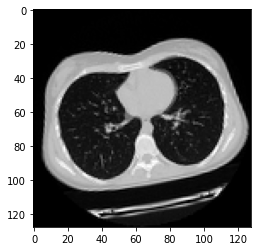

In [47]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
imges = images.numpy()
image = images[0]
print(f'dimension of the CT scan is:', image.shape)
plt.imshow(np.squeeze(image[:,:,30]), cmap='gray')

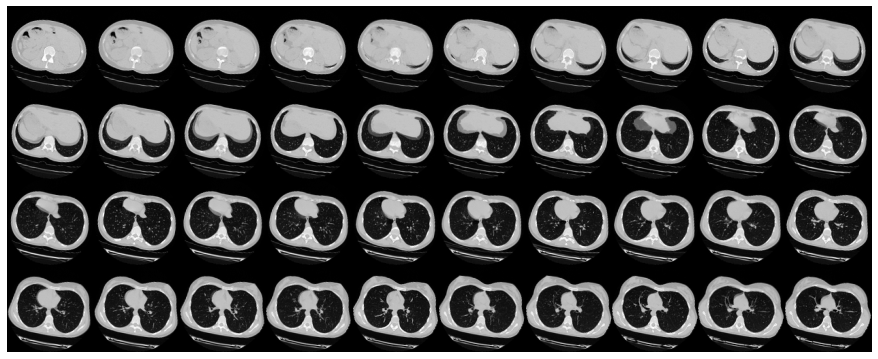

In [48]:
# draw ct scans

def plot_slices(num_rows, num_columns, width, height, data):
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data] # heights of for rows
    widths = [slc.shape[1] for slc in data[0]] # widths of first row elements data[0] means first row

    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize = (fig_width, fig_height),
        gridspec_kw={'height_ratios': heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap='gray')
            axarr[i, j].axis('off')

    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()

plot_slices(4, 10, 128, 128, image[:, :, :40])

In [49]:
## build a model for 3d scan

def get_model(width=128, height=128, depth=64):

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation='relu')(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation='relu')(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation='relu')(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation='relu')(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation='sigmoid')(x)

    #define the model
    model = keras.Model(inputs, outputs, name='3dcnn')
    return model

model = get_model(width=128, height=128, depth=64)
model.summary()



Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d_4 (Conv3D)           (None, 126, 126, 62, 64)  1792      
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 63, 63, 31, 64)   0         
 3D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 63, 63, 31, 64)   256       
 hNormalization)                                                 
                                                                 
 conv3d_5 (Conv3D)           (None, 61, 61, 29, 64)    110656    
                                                             

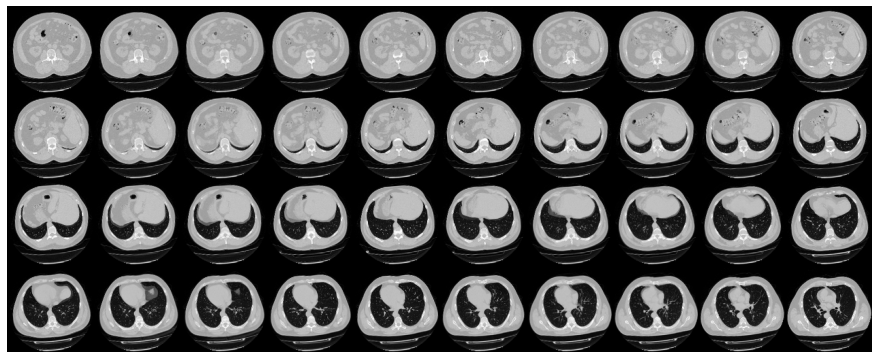

1


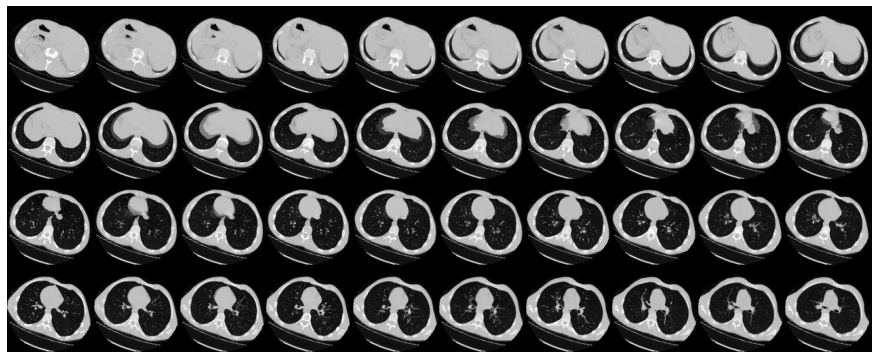

1


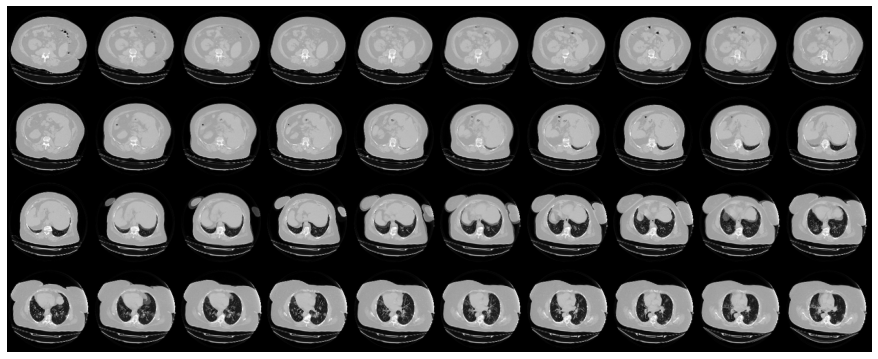

1


In [67]:
samples = list(train_dataset.as_numpy_iterator())
for idx in range(3):
    plot_slices(4, 10, 128, 128, samples[idx][0][0][:, :, :40])
    print(samples[idx][1][0])

In [50]:
# train the model

initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.96, staircase=True
)

model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=['acc']
)

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    '3d_image_classification.h5', save_best_only=True
)

eary_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_acc', patience=15)

epochs = 100
model.fit(
    train_dataset,
    validation_data = validation_dataset,
    epochs = epochs,
    shuffle=True,
    verbose=2,
    callbacks =[checkpoint_cb, eary_stopping_cb]
)





Epoch 1/100
70/70 - 13s - loss: 0.2930 - acc: 0.9643 - val_loss: 2.3140 - val_acc: 0.5000 - 13s/epoch - 180ms/step
Epoch 2/100
70/70 - 12s - loss: 0.1375 - acc: 1.0000 - val_loss: 5.9503 - val_acc: 0.5000 - 12s/epoch - 173ms/step
Epoch 3/100
70/70 - 12s - loss: 0.0751 - acc: 1.0000 - val_loss: 8.8588 - val_acc: 0.5000 - 12s/epoch - 173ms/step
Epoch 4/100
70/70 - 12s - loss: 0.0702 - acc: 1.0000 - val_loss: 13.2422 - val_acc: 0.5000 - 12s/epoch - 172ms/step
Epoch 5/100
70/70 - 12s - loss: 0.0563 - acc: 1.0000 - val_loss: 13.7473 - val_acc: 0.5000 - 12s/epoch - 171ms/step
Epoch 6/100
70/70 - 12s - loss: 0.0357 - acc: 1.0000 - val_loss: 15.7764 - val_acc: 0.5000 - 12s/epoch - 171ms/step
Epoch 7/100
70/70 - 12s - loss: 0.0223 - acc: 1.0000 - val_loss: 8.1378 - val_acc: 0.5000 - 12s/epoch - 170ms/step
Epoch 8/100
70/70 - 12s - loss: 0.0183 - acc: 1.0000 - val_loss: 17.7588 - val_acc: 0.5000 - 12s/epoch - 171ms/step
Epoch 9/100
70/70 - 12s - loss: 0.0186 - acc: 1.0000 - val_loss: 8.9423 - va

KeyboardInterrupt: 